In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
def sin_trajectory(t):
    return math.sin(t)

In [3]:
def plot_trajectory(trajectory, estimated_trajectory, 
                    generator_function, estimation_function,
                    title):
    plt.figure(figsize=(8, 4))
    plt.plot(trajectory[:, 0].numpy(), trajectory[:, 1].numpy(), label=f'{generator_function}(t)')
    plt.plot(estimated_trajectory[:, 0].numpy(), estimated_trajectory[:, 1].numpy(), label=f'{estimation_function}(t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
PERIOD = 4
times = torch.linspace(0, PERIOD * 2 * math.pi, steps=(PERIOD * 100))
values = torch.tensor([sin_trajectory(t.item()) for t in times])
trajectory = torch.stack([times, values], dim=1)

In [5]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim + 1] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)
	
	def forward(self, t, x):
		state = torch.cat([t.unsqueeze(0), x], dim=0)
		x_dot = self.mlp(state)
		return x_dot

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
ode = ODE(2, (256 for _ in range(3))).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 113.14218139648438
Epoch 2, Loss: 92.35501861572266
Epoch 3, Loss: 74.70382690429688
Epoch 4, Loss: 58.660404205322266
Epoch 5, Loss: 44.072792053222656
Epoch 6, Loss: 31.710912704467773
Epoch 7, Loss: 22.058895111083984
Epoch 8, Loss: 14.901185989379883
Epoch 9, Loss: 9.994136810302734
Epoch 10, Loss: 7.422555923461914
Epoch 11, Loss: 7.211884498596191
Epoch 12, Loss: 8.665504455566406
Epoch 13, Loss: 10.549844741821289
Epoch 14, Loss: 11.826696395874023
Epoch 15, Loss: 12.061213493347168
Epoch 16, Loss: 11.36270809173584
Epoch 17, Loss: 10.082043647766113
Epoch 18, Loss: 8.592137336730957
Epoch 19, Loss: 7.198268890380859
Epoch 20, Loss: 6.057961940765381
Epoch 21, Loss: 5.235859394073486
Epoch 22, Loss: 4.734165668487549
Epoch 23, Loss: 4.509463310241699
Epoch 24, Loss: 4.489365577697754
Epoch 25, Loss: 4.591563701629639
Epoch 26, Loss: 4.741251468658447
Epoch 27, Loss: 4.880563735961914
Epoch 28, Loss: 4.969601154327393
Epoch 29, Loss: 4.986393928527832
Epoch 30, Los

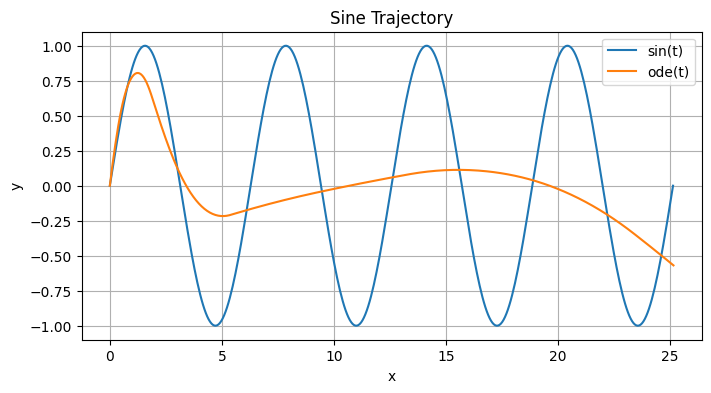

In [8]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')

In [12]:
class FourierFeatureODE(nn.Module):
    def __init__(self, input_dim, hidden_dims, fourier_scale=10.0, num_fourier_features=10, random_features=False):
        super(FourierFeatureODE, self).__init__()
        
        self.input_dim = input_dim
        self.num_fourier_features = num_fourier_features
        
        self.random_features = random_features
        self.register_buffer('B', torch.randn(input_dim, num_fourier_features) * fourier_scale)
        
        fourier_expanded_dim = input_dim + 2 * num_fourier_features
        dim_list = [fourier_expanded_dim + 1] + list(hidden_dims) + [input_dim]
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i < len(dim_list) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
    
    def compute_positional_fourier_features(self, x):
        encodings = [x]
        for i in range(self.num_fourier_features // 2):
            freq = 2.0 ** i
            sin_features = torch.sin(freq * x)
            cos_features = torch.cos(freq * x)
            encodings.append(sin_features)
            encodings.append(cos_features)
        return torch.cat(encodings, dim=-1)

    def forward(self, t, x):
        x_fourier = self.compute_positional_fourier_features(x)
        state = torch.cat([t.unsqueeze(0), x_fourier], dim=0)
        x_dot = self.mlp(state)
        return x_dot

In [15]:
ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=8).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 106.51433563232422
Epoch 2, Loss: 100.02757263183594
Epoch 3, Loss: 86.70978546142578
Epoch 4, Loss: 76.69120788574219
Epoch 5, Loss: 67.14308166503906
Epoch 6, Loss: 59.02246856689453
Epoch 7, Loss: 52.02259063720703
Epoch 8, Loss: 44.63056182861328
Epoch 9, Loss: 38.11532211303711
Epoch 10, Loss: 32.22377014160156
Epoch 11, Loss: 26.820297241210938
Epoch 12, Loss: 21.844173431396484
Epoch 13, Loss: 17.35623550415039
Epoch 14, Loss: 13.485021591186523
Epoch 15, Loss: 10.40203857421875
Epoch 16, Loss: 8.27688217163086
Epoch 17, Loss: 7.239369869232178
Epoch 18, Loss: 7.303318977355957
Epoch 19, Loss: 8.223132133483887
Epoch 20, Loss: 9.500898361206055
Epoch 21, Loss: 10.595325469970703
Epoch 22, Loss: 11.159162521362305
Epoch 23, Loss: 11.106820106506348
Epoch 24, Loss: 10.47460651397705
Epoch 25, Loss: 9.034512519836426
Epoch 26, Loss: 8.103407859802246
Epoch 27, Loss: 7.483051776885986
Epoch 28, Loss: 6.9392900466918945
Epoch 29, Loss: 6.535416126251221
Epoch 30, Loss:

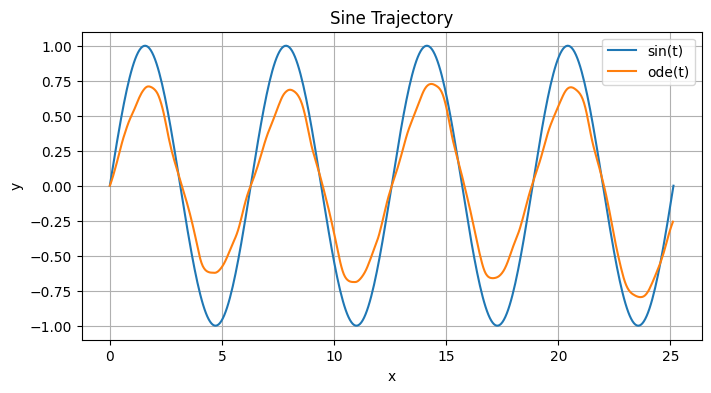

In [16]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')